In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import scipy.signal as signal
from beam.beams import laserbeam
from beam.elements import thickoptic
from beam import interactions
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
plt.style.use('notes')
import matplotlib.colors as colors

path = '/media/robert/Data_Storage/Data/Diagnostic/Phase_Diagnostic/GlassRod/'
lam = 0.6328

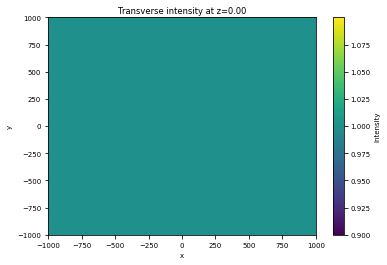

In [2]:
# Glass Rod
N = 2**14
Ny = 1
Nz = 4000
X = 2e3
Y = 2e3
Z = 2e3
beamParams = {
    'Nx' : N,
    'Ny' : Ny,
    'X' : X,
    'Y' : Y,
    'lam' : lam,
    'path' : path,
    'name' : 'HeNe',
    'load' : False,
    'threads' : 4,
    'cyl' : False,
    'E0' : 27.44923,
    'waist' : 1e3,
    'z0' : 0
}
#beam = laserbeam.GaussianLaser(beamParams)
beam = laserbeam.Laser(beamParams)
beam.initialize_field(np.ones((N, Ny))*27.44923)
beam.plot_current_intensity()

indexParams = {
    'Nx' : N,
    'Ny' : Ny,
    'Nz' : Nz,
    'X' : X,
    'Y' : Y,
    'Z' : Z,
    'path' : path,
    'name' : 'GRIN',
    'lam' : lam,
    'load' : False,
}
rod = thickoptic.Index(indexParams)
x = np.linspace(-X/2, X/2, 4*N, False, dtype='double')
y = np.linspace(-Y/2, Y/2, Ny, False, dtype='double')
z = np.linspace(0, Z, 4*Nz, False, dtype='double')
x = np.reshape(x, (4*N, 1, 1))
y = np.reshape(y, (1, Ny, 1))
z = np.reshape(z, (1, 1, 4*Nz))
n = np.ones((4*N, Ny, 4*Nz))
sel = x**2+(z-1e3)**2 < 0.5e3**2
sel = np.repeat(sel, Ny, axis=1)

n[sel] = 1.5

/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/scipy/signal/signaltools.py:3402: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


(16384, 1, 4000)


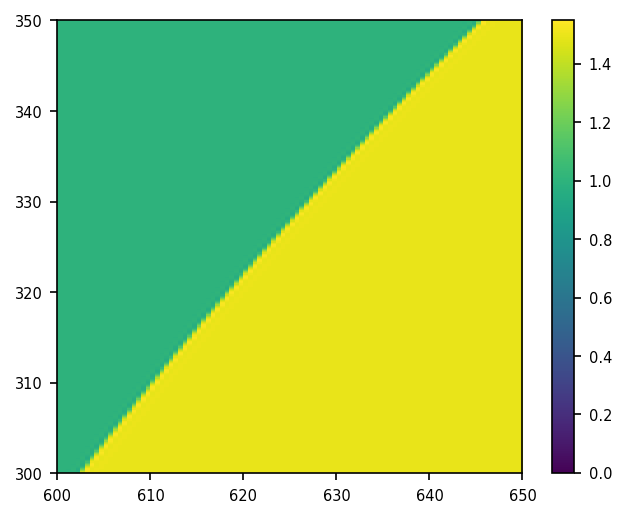

In [3]:
n = signal.decimate(n, 4, axis=0, ftype='fir')
n = signal.decimate(n, 4, axis=2, ftype='fir')
print(np.shape(n))
plt.figure(figsize=(5, 4), dpi=150)
plt.imshow(n[:, int(Ny/2), :], aspect='auto', extent=[0, 2e3, -1e3, 1e3])
cb = plt.colorbar()
plt.xlim(600, 650)
plt.ylim(300, 350)
plt.show()
rod.initialize_index(n)

In [4]:
interactions.beam_index(beam, rod)
beam.propagate(rod.z, 1)

In [5]:
field = np.zeros((N, 2*Nz), dtype='complex')
#I = np.zeros((N, Nz), dtype='double')
for i in range(2*Nz):
    field[:, i] = beam.load_field(i)[0][:, int(Ny/2)]
I = beam.intensity_from_field(field)
del beam

In [6]:
I2 = signal.decimate(I, 4, axis=0, ftype='fir')

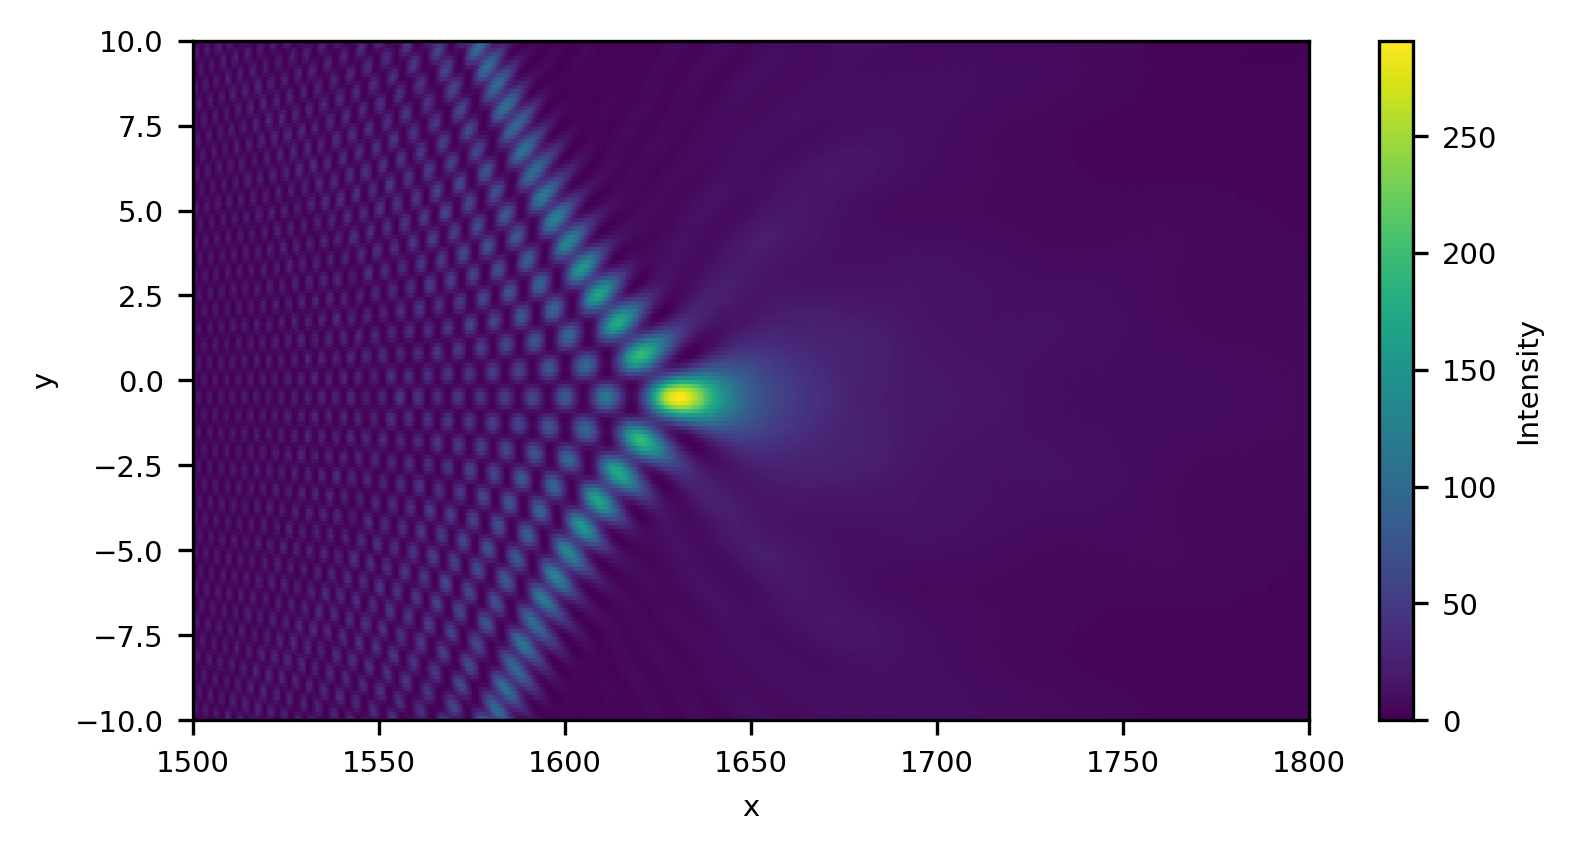

In [7]:
plt.figure(figsize=(6, 3), dpi=300)
plt.imshow(I, aspect='auto', extent=[0, 4e3, -X/2, X/2], vmin=0, interpolation='none')
cb = plt.colorbar()
cb.set_label(r'Intensity')
plt.set_cmap('viridis')
plt.xlabel(r'z')
plt.ylabel(r'x')
plt.ylim(-10, 10)
plt.xlim(1.5e3, 1.8e3)
plt.show()

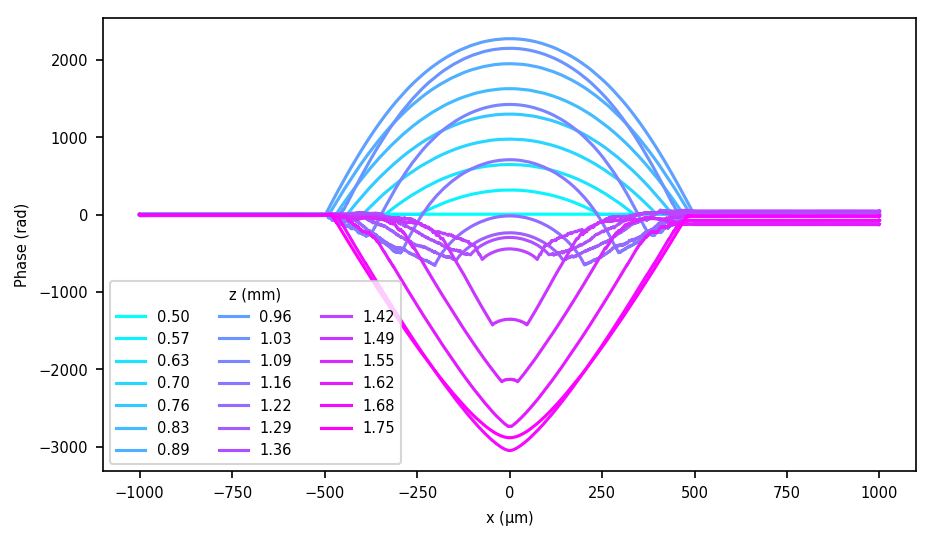

In [46]:
# Phase inside the lens
z = np.linspace(0, 2*Z, 2*Nz)
phase = np.unwrap(np.angle(field[:, 4000]))
zphase = np.linspace(1000, 3500, 20, dtype='int')

plt.figure(figsize=(7, 4), dpi=150)
ax = plt.subplot()
ax.set_prop_cycle('color',
                      [plt.cm.cool(i) for i in np.linspace(0, 1, len(zphase))])
for i in range(len(zphase)):
    phase = np.unwrap(np.angle(field[:, zphase[i]]))
    plt.plot(rod.x, phase, label='%0.2f' % (z[zphase[i]]/1e3))
plt.legend(title='z (mm)', loc=3, ncol=3)
plt.xlabel(r'x ($\mathrm{\mu m}$)')
plt.ylabel('Phase (rad)')
plt.show()

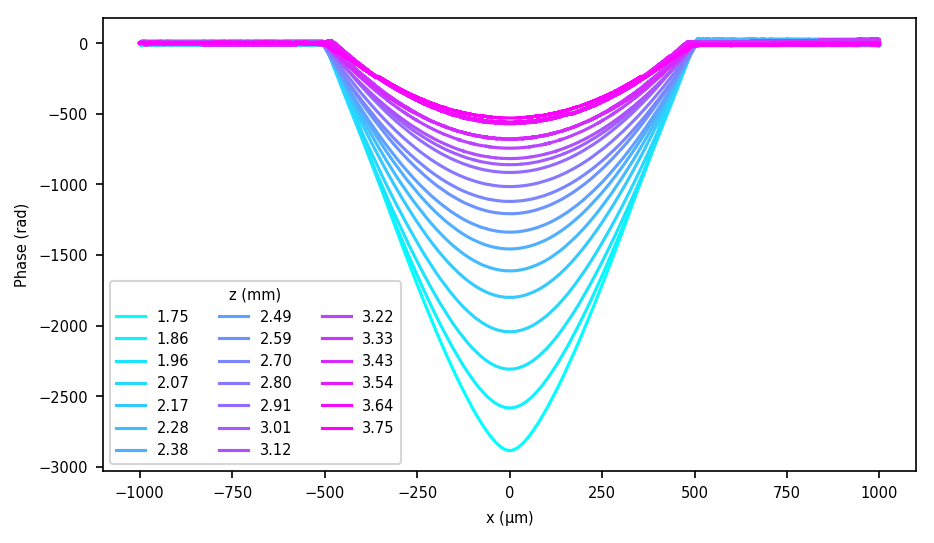

In [53]:
# Phase after the lens
z = np.linspace(0, 2*Z, 2*Nz)
phase = np.unwrap(np.angle(field[:, 4000]))
zphase = np.linspace(3500, 7500, 20, dtype='int')

plt.figure(figsize=(7, 4), dpi=150)
ax = plt.subplot()
ax.set_prop_cycle('color',
                      [plt.cm.cool(i) for i in np.linspace(0, 1, len(zphase))])
for i in range(len(zphase)):
    phase = np.unwrap(np.angle(field[:, zphase[i]]))
    plt.plot(rod.x, phase, label='%0.2f' % (z[zphase[i]]/1e3))
plt.legend(title='z (mm)', loc=3, ncol=3)
plt.xlabel(r'x ($\mathrm{\mu m}$)')
plt.ylabel('Phase (rad)')
plt.show()

/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/scipy/signal/signaltools.py:3402: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


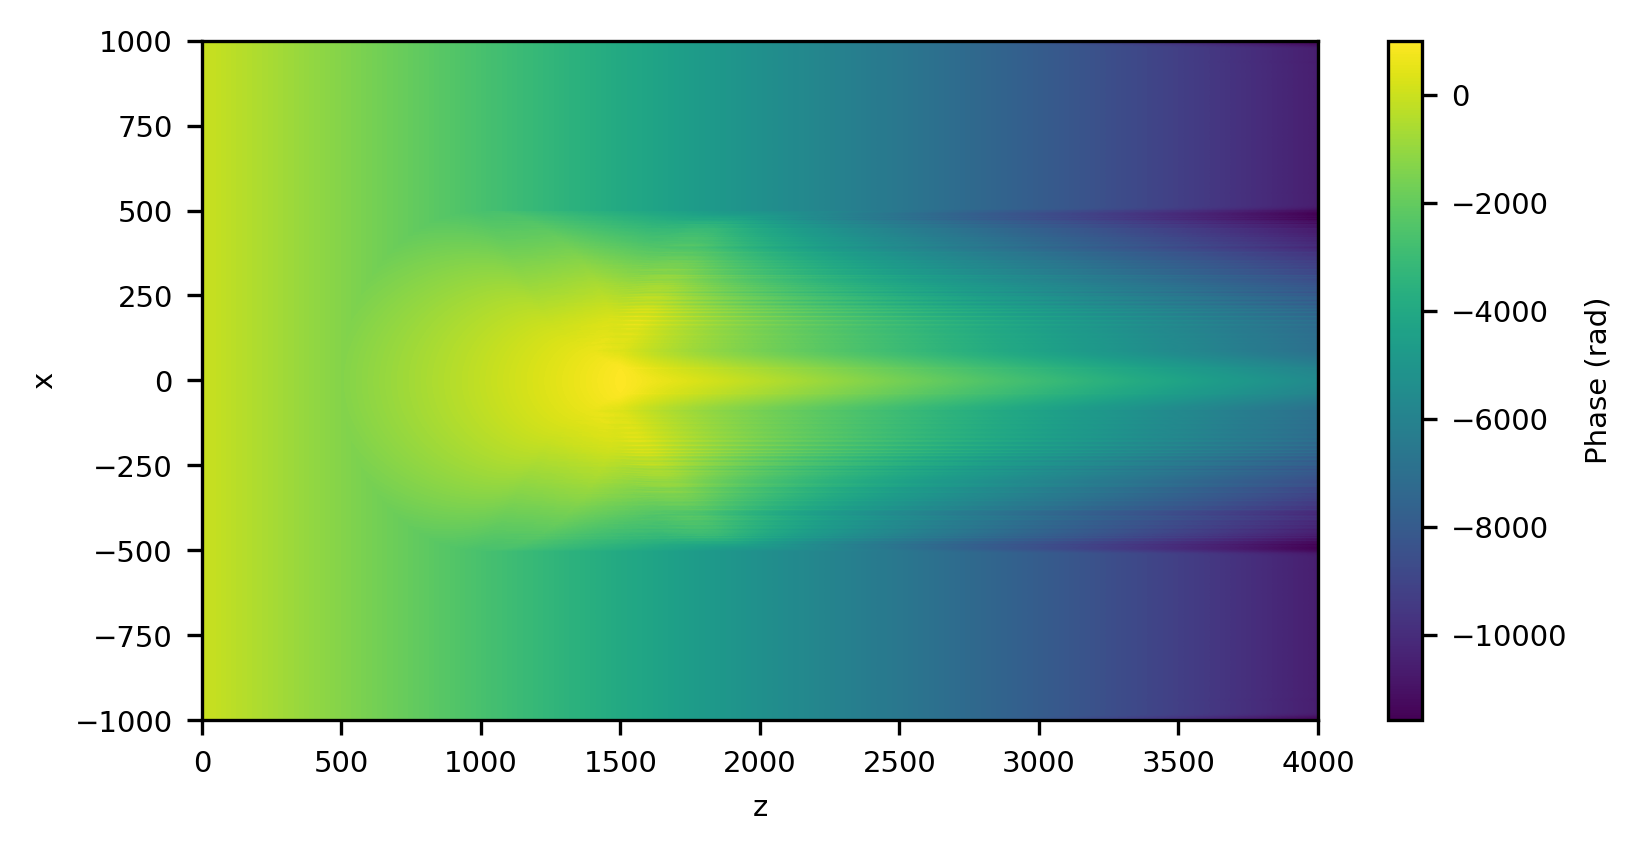

In [51]:
phi = signal.decimate(np.unwrap(np.angle(field), axis=1), 4, axis=0, ftype='fir')
plt.figure(figsize=(6, 3), dpi=300)
plt.imshow(phi, aspect='auto', extent=[0, 4e3, -X/2, X/2], interpolation='none')
cb = plt.colorbar()
cb.set_label(r'Phase (rad)')
plt.set_cmap('viridis')
plt.xlabel(r'z')
plt.ylabel(r'x')
#plt.ylim(-10, 10)
#plt.xlim(1.5e3, 1.8e3)
plt.show()